In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_curve,roc_auc_score
from lightgbm import LGBMClassifier,plot_importance,plot_metric
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV

In [100]:
def fillrate_1(df):
    data=pd.DataFrame(columns=['variable','unique_values',
                               'fill rate'])
    for var in df.columns:
        if ((df[var].dtype!='object') and (df[var].dtype!='datetime64[ns]')):
            fill_rate=np.round((1-(df[var].isnull().sum()/len(df[var])))*100,3)
            data=data.append({'variable':var,'unique_values':len(df[var].value_counts()),'fill rate':fill_rate},ignore_index=True)
        else:
            fill_rate=np.round((1-(df[var].isnull().sum()/len(df[var])))*100,3)
            data=data.append({'variable':var,'unique_values':len(df[var].value_counts()),'fill rate':fill_rate},ignore_index=True)
            
    return data
def fillrate(df):
    data=pd.DataFrame(columns=['variable','unique_values','count','mean','median','mode','max','min',
                               'fill rate'])
    for var in df.columns:
        if ((df[var].dtype!='object') and (df[var].dtype!='datetime64[ns]')):
            fill_rate=np.round((1-(df[var].isnull().sum()/len(df[var])))*100,3)
            data=data.append({'variable':var,'unique_values':len(df[var].value_counts()),'count':len(df[var]),
                         'mean':np.round(df[var].mean(),3),'median':np.round(df[var].median(),3),'mode':np.NAN,'max':df[var].max(),
                          'min':df[var].min(),'fill rate':fill_rate},ignore_index=True)
        else:
            fill_rate=np.round((1-(df[var].isnull().sum()/len(df[var])))*100,3)
            data=data.append({'variable':var,'unique_values':len(df[var].value_counts()),'count':len(df[var]),
                         'mean':np.NAN,'median':np.NAN,'mode':df[var].mode()[0],'max':np.NAN,
                          'min':np.NAN,'fill rate':fill_rate},ignore_index=True)
                        

    return data


def iv_woe(data, target, bins=10):
    
    newDF = pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] =np.maximum(d['Events'],1) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'],1) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        
    return newDF
def ks(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 10)
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,11)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 9)
    ks=kstable.KS.max()
    return kstable,ks


def scorecard(model,X_train,X_test):
    y_pred=model.predict(X_test)
    y_prob=model.predict_proba(X_test)[:,1]
    cc=confusion_matrix(y_test,y_pred)
    TN=cc[0,0]
    TP=cc[1,1]
    FP=cc[0,1]
    FN=cc[1,0]
    accuracy=(TP+TN)/(TP+TN+FP+FN)
    precision=TP/(TP+FP)
    recall=TP/(TP+FN)
    Tpr=TP/(TP+FN)
    Fpr=FP/(FP+TN)
    f1_ratio=2*((recall*precision)/(precision+recall))
    auc_test=roc_auc_score(y_test,y_pred)
    data=pd.DataFrame({'y':y_test,'p':y_prob})
    a,ks_test=ks(data=data,target='y',prob='p')
    y_pred_tr=model.predict(X_train)
    y_prob_tr=model.predict_proba(X_train)[:,1]
    cctrain=confusion_matrix(y_train,y_pred_tr)
    TN=cctrain[0,0]
    TP=cctrain[1,1]
    FP=cctrain[0,1]
    FN=cctrain[1,0]
    accuracy_tr=(TP+TN)/(TP+TN+FP+FN)
    precision_tr=TP/(TP+FP)
    recall_tr=TP/(TP+FN)
    Tpr_tr=TP/(TP+FN)
    Fpr_tr=FP/(FP+TN)
    f1_ratio_tr=2*((recall_tr*precision_tr)/(precision_tr+recall_tr))
    auc_tr=roc_auc_score(y_train,y_pred_tr)
    data_r=pd.DataFrame({'y':y_train,'p':y_prob_tr})
    a,ks_train=ks(data=data_r,target='y',prob='p')
    df=pd.DataFrame({'metrics':['accuracy','precision','recall','TPR','FPR','f1_ratio','auc_score','ks statistics'],
                     'train':[accuracy_tr,precision_tr,recall_tr,Tpr_tr,Fpr_tr,f1_ratio_tr,auc_tr,ks_train],
                      'test':[accuracy,precision,recall,Tpr,Fpr,f1_ratio,auc_test,ks_test]})
    df=df.set_index('metrics')
    return df
    
def raw_to_woe_values(data, target, bins=10):
    
    df = data.copy()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': target})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': target})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] =np.maximum(d['Events'],1) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'],1) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        z=list(d['Cutoff'])
        j=list(d['WoE'])
        dic={z[i]:j[i] for i in range(len(d))}
        df[ivars]=d0['x'].map(dic)
        
        
    return df
def correlation(d,poscutoff,negcutoff):
    v1=[]
    v2=[]
    corr=[]
    for a in d.columns:
        for b in d.drop(labels=a,axis=1).columns:
            if d[a].corr(d[b])>poscutoff:
                v1.append(a)
                v2.append(b)
                corr.append(d[a].corr(d[b]))
            elif d[a].corr(d[b])<negcutoff:
                v1.append(a)
                v2.append(b)
                corr.append(d[a].corr(d[b]))
    df=pd.DataFrame({'v1':v1,'v2':v2,'corr':corr})
    
    return df
def iv_woe_pop(data, target, bins=10):
    
    df = pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    list_vars=[]
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['pop']=d['N']/d['N'].sum()*100
        df[ivars]=d['pop']        
        list_vars.append(ivars) 
        
    return list_vars,df
def iv_woe_trend(data, target, bins=10):
    
    df = pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    list_vars=[]
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['pop']=d['N']/d['N'].sum()*100
        d['% of Events'] =np.maximum(d['Events'],1) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'],1) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        df[ivars]=d['WoE']  
    return df
def out_kstable(out_woe,model,decile,target):
    pred=model.predict(out_woe)
    y_prob=model.predict_proba(out_woe)[:,1]
    d=pd.DataFrame({'target':target,'prob':y_prob})
    a=[]
    for i in range(len(d)):
        
        if d.prob.iloc[i]>decile[2]:
            a.append('1')
        elif d.prob.iloc[i]>decile[3]:
            a.append('2')
        elif d.prob.iloc[i]>decile[4]:
            a.append('3')
        elif d.prob.iloc[i]>decile[5]:
            a.append('4')
        elif d.prob.iloc[i]>decile[6]:
            a.append('5')
        elif d.prob.iloc[i]>decile[7]:
            a.append('6')
        elif d.prob.iloc[i]>decile[8]:
            a.append('7')
        elif d.prob.iloc[i]>decile[9]:
            a.append('8')
        elif d.prob.iloc[i]>decile[10]:
            a.append('9')
        else:
            a.append('10')
    d['buckets']=a
    
    d['target0']=1-d['target']
    grouped = d.groupby('buckets', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()['prob']
    kstable['max_prob'] = grouped.max()['prob']
    kstable['events']   = grouped.sum()['target']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['nonevents'] =grouped.sum()['target0']    
    kstable['event_rate'] = (kstable.events / d['target'].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / d['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / d['target'].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / d['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100
    kstable.index = range(1,11)
    kstable.index.rename('Decile', inplace=True)
    return kstable 
def band_map(data,model,decile,target):
    y_prob=model.predict_proba(data)[:,1]
    d=pd.DataFrame({'target':target,'prob':y_prob,'cid':data.cid})
    a=[]
    for i in range(len(d)):
        
        if d.prob.iloc[i]>decile[2]:
            a.append('1')
        elif d.prob.iloc[i]>decile[3]:
            a.append('2')
        elif d.prob.iloc[i]>decile[4]:
            a.append('3')
        elif d.prob.iloc[i]>decile[5]:
            a.append('4')
        elif d.prob.iloc[i]>decile[6]:
            a.append('5')
        elif d.prob.iloc[i]>decile[7]:
            a.append('6')
        elif d.prob.iloc[i]>decile[8]:
            a.append('7')
        elif d.prob.iloc[i]>decile[9]:
            a.append('8')
        elif d.prob.iloc[i]>decile[10]:
            a.append('9')
        else:
            a.append('10')
    d['buckets']=a
    
    return d  

def band_mapping(modelBase,predProb ,bandProb_ds):
    '''
    This function tags the band based on train data
    
    param :
        modelBase : model dataframe 
        predProb : str, predicted_prob feature name
        bandProb_ds : dataframe with traning smry dict, contains min, max range of probablities for each brand
        
    return:
        dataframe with band tag
    
    '''
    
    var2=[]
    var3 =[]
    cutoff_pts = bandProb_ds['max_prob']
    for i in range(0,len(modelBase)):
        var1 = []
        for j in range(1,len(cutoff_pts)):
            if (modelBase[predProb].iloc[i] < cutoff_pts[j-1]):
                var1.append(j)
                if len(var1)==0:
                    print(modelBase[predProb][i])
                    print(cutoff_pts[j-1])
                    

        if len(var1)==0:
            var1 = []
        else:
            var1 = min(var1)
        var3.append(var1)
        var2.append(i)

    ds = pd.DataFrame({'idx':var2,'band':var3})
    ds['key'] = modelBase['key']
    # ds['band'] = ds['band'] + 1
    return(ds)

# Reading data set

In [3]:
df=pd.read_parquet('MASTER_DF_short_term_more_than3_with_delay.parquet',engine='fastparquet')
df.head()

,cid,app_lst3_sync_trend_bnk,app_lst3_sync_slope_bnk,app_lst3_sync_trend_tvl,app_lst3_sync_slope_tvl,app_lst3_sync_trend_auto,app_lst3_sync_slope_auto,app_lst3_sync_trend_but,app_lst3_sync_slope_but,app_lst3_sync_trend_bk,...,wallet_overall_cnt_bills_due_90_days,wallet_overall_cnt_bills_due_30_days,wallet_overall_amt_avg_total_credit_transactions_12_months,wallet_overall_amt_avg_total_credit_transactions_6_months,wallet_overall_amt_avg_total_credit_transactions_3_months,wallet_overall_amt_avg_total_debit_transactions_12_months,wallet_overall_amt_avg_total_debit_transactions_6_months,wallet_overall_amt_avg_total_debit_transactions_3_months,Max_delay_all,Max_delay_last2
0,65782,-2.0,0.000000,-2.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,10.0,8.0,6641.580000,8948.17,10106.0,10075.200,13919.200,14014.500,-24,-37
1,66488,-1.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,10647.000000,10647.00,10647.0,31019.000,31019.000,31019.000,8,6
2,171270,-1.0,0.000000,1.0,0.880797,0.0,0.0,0.0,0.0,0.0,...,49.0,28.0,0.000000,0.00,0.0,0.000,0.000,0.000,0,0
3,204497,1.0,0.982014,-2.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.083333,0.00,0.0,155.287,144.188,240.313,0,-30
4,331733,-2.0,0.000000,-2.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5,-5


In [4]:
print(' there are',df.shape[0],' rows and ',df.shape[1],' variables in the dataset')
print('data types in data is')
df.dtypes.value_counts()


 there are 11563  rows and  3033  variables in the dataset
data types in data is


float64           3011
int64               18
object               3
datetime64[ns]       1
dtype: int64

# Deciding bad and good customers based on max delay variable

target variable

Max_delay_all<=2 is non_event ,

max_dela_all>=15 event,

rest are grey

In [5]:
target=[]
for i in range(len(df)):
    if df['Max_delay_all'].iloc[i]<=2:
        target.append('non event')
    elif df['Max_delay_all'].iloc[i]>=15:
        target.append('event')
    else:
        target.append('grey')
        
df['event']=target

In [6]:
df.event.value_counts(normalize=True)*100

non event    77.609617
event        16.189570
grey          6.200813
Name: event, dtype: float64

The above Event rate shows that there are only 6.2% of grey customers in the data so it does not help in classification of customers so dropping all grey customers

In [51]:
index_to_drop=df[df.event=='grey'].index
df1=df.drop(index_to_drop)
print('before drop grey customer',df.shape)
print('after droping grey customer',df1.shape)

before drop grey customer (11563, 3034)
after droping grey customer (10846, 3034)


droping all unique variables like cid ,loanid, datetime variable and max delay

In [71]:
b=[col for col in df.columns if col.endswith('contact_record')]
#a=[col for col in df.columns if col.endswith('id')]
b
df2=df1.drop(labels=b,axis=1)
df3=df2.drop(labels=['Max_delay_all','Max_delay_last2','casa_overall_regex_variable_created_on'],axis=1)
print('before droping variables',df1.shape)
print('after droping variables',df3.shape)

before droping variables (10846, 3034)
after droping variables (10846, 3029)


# Coverage analysis

Fill rate is ratio of number of non null data points to the total number of data points.

Fill rate is useful for the Feature selection, because fill rate tells how much percentage of data a particular variable has.

using fillrate cutoff as 60%, assuming the variables with fillrate less than 60%, it does not give information


In [72]:
Fr_variables=fillrate(df3)
Fr_variables.head()

,variable,unique_values,count,mean,median,mode,max,min,fill rate
0,cid,10846,10846,2.006847e+07,24220277.0,NaN,28550975,2094,100.000
1,app_lst3_sync_trend_bnk,5,10846,-2.905600e+01,0.0,NaN,1.0,-9999.0,93.223
2,app_lst3_sync_slope_bnk,9,10846,-2.826300e+01,0.5,NaN,1.0,-9999.0,93.223
3,app_lst3_sync_trend_tvl,5,10846,-2.945100e+01,0.0,NaN,1.0,-9999.0,93.223
4,app_lst3_sync_slope_tvl,9,10846,-2.854700e+01,0.0,NaN,1.0,-9999.0,93.223


In [73]:
#dropping variables with fillrate < or =60%
columns=list(Fr_variables[Fr_variables['fill rate']<=60].variable)
df_60_fillrate=df3.drop(labels=columns,axis=1)
print('before drop',df3.shape)
print('after drop', df_60_fillrate.shape)
#encoding target variable
dic={'non event':0,'event':1}
df_60_fillrate['event']=df_60_fillrate['event'].map(dic)

before drop (10846, 3029)
after drop (10846, 3020)


Replacing all nan values by placeholder value -9999 beacuase placeholder is also a missing value while fetching data

In [74]:
df_60_fillrate=df_60_fillrate.fillna(-9999)

# IV values

IV (Information value) : Information value is the single value representing the entire feature’s predictive power. This will be useful during the feature selection.  

                                 IV = ∑ (% of non-events - % of events) * WOE
                                 
based on IV values we can select Variables with higher information


In [75]:
iv=iv_woe(data=df_60_fillrate,target='event',bins=10)
iv=iv.set_index('Variable')

In [76]:
#creating buckest for IV value
buckets=[]
for i in range(len(iv)):
    if iv.IV.iloc[i]<=0.001:
        buckets.append('<=0.001')
    elif iv.IV.iloc[i]<=0.005:
        buckets.append('.001 to 0.005')
    elif iv.IV.iloc[i]<=0.02:
        buckets.append('0.005 to 0.02')
    elif iv.IV.iloc[i]<=0.1:
        buckets.append('0.02 to 0.1')
    else:
        buckets.append('>0.1')
        
        
iv['buckets']=buckets
iv.groupby('buckets').agg('count')

,IV
buckets,
.001 to 0.005,410
0.005 to 0.02,679
0.02 to 0.1,1412
<=0.001,326
>0.1,192


In [77]:
#cutoff is 0.02droping variables with IV value <0.02
cols=iv[iv.IV<0.02].index
data=df_60_fillrate.drop(labels=cols,axis=1)
print('before drop',df_60_fillrate.shape)
print('after drop ',data.shape)

before drop (10846, 3020)
after drop  (10846, 1605)


In [78]:
data=data.fillna(-9999)

# splitting data

In [79]:
X=data.drop(labels='event',axis=1)
y=data['event']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,stratify=y)


Checking for distribution of event rate i train and test

In [80]:
print('train',y_train.value_counts(normalize=True))
print('test',y_test.value_counts(normalize=True))

train 0    0.827455
1    0.172545
Name: event, dtype: float64
test 0    0.827189
1    0.172811
Name: event, dtype: float64


# building base LR model

In [81]:
lr1=LogisticRegression()
lr1.fit(X_train,y_train)
score1=scorecard(lr1,X_train,X_test)
score1

/home/srikanth/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


,train,test
metrics,,
accuracy,0.824804,0.824424
precision,0.189189,0.200000
recall,0.004676,0.005333
TPR,0.004676,0.005333
FPR,0.004179,0.004457
f1_ratio,0.009126,0.010390
auc_score,0.500249,0.500438
ks statistics,24.700000,23.500000


In [82]:
y_prob=lr1.predict_proba(X_train)[:,1]
d=pd.DataFrame({'y':y_train,'p':y_prob})
kstable_final_lr,ks_stat=ks(data=d,target='y',prob='p')
kstable_final_lr

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,
1,2.806431e-01,0.986228,272,596,18.17%,8.30%,18.17%,8.30%,9.9
2,2.441648e-01,0.280636,273,594,18.24%,8.27%,36.41%,16.58%,19.8
3,2.228442e-01,0.244160,204,664,13.63%,9.25%,50.03%,25.83%,24.2
4,2.078152e-01,0.222842,156,711,10.42%,9.90%,60.45%,35.73%,24.7
5,1.916508e-01,0.207794,146,722,9.75%,10.06%,70.21%,45.79%,24.4
6,1.720053e-01,0.191628,125,742,8.35%,10.34%,78.56%,56.12%,22.4
7,1.449575e-01,0.171932,104,764,6.95%,10.64%,85.50%,66.76%,18.7
8,1.103833e-01,0.144921,97,770,6.48%,10.73%,91.98%,77.49%,14.5
9,5.701644e-02,0.110349,65,803,4.34%,11.19%,96.33%,88.68%,7.7


In [98]:
table=out_kstable(X_test,lr1,kstable_final_lr.max_prob,target=y_test)
table

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,
1,2.808530e-01,0.999914,64,133,17.07%,7.41%,0.170667,0.074095,9.7
2,2.443492e-01,0.280117,67,199,17.87%,11.09%,0.349333,0.184958,16.4
3,2.228986e-01,0.244066,56,156,14.93%,8.69%,0.498667,0.271866,22.7
4,2.081299e-01,0.222754,37,188,9.87%,10.47%,0.597333,0.376602,22.1
5,1.918096e-01,0.207794,39,173,10.40%,9.64%,0.701333,0.472981,22.8
6,1.720477e-01,0.191618,30,203,8.00%,11.31%,0.781333,0.586072,19.5
7,1.451392e-01,0.171884,22,174,5.87%,9.69%,0.840000,0.683008,15.7
8,1.106730e-01,0.144909,21,186,5.60%,10.36%,0.896000,0.786630,10.9
9,5.707028e-02,0.110014,18,189,4.80%,10.53%,0.944000,0.891922,5.2


In [111]:
def band_mapping(modelBase,predProb ,bandProb_ds):
    '''
    This function tags the band based on train data
    
    param :
        modelBase : model dataframe 
        predProb : str, predicted_prob feature name
        bandProb_ds : dataframe with traning smry dict, contains min, max range of probablities for each brand
        
    return:
        dataframe with band tag
    
    '''
    
    var2=[]
    var3 =[]
    cutoff_pts = list(bandProb_ds['max_prob'])
    for i in range(0,len(modelBase)):
        var1 = []
        for j in range(1,len(cutoff_pts)+1):
            if (modelBase[predProb].iloc[i] < cutoff_pts[j-1]):
                var1.append(j)
                if len(var1)==0:
                    print(modelBase[predProb][i])
                    print(cutoff_pts[j-1])
                    

        if len(var1)==0:
            var1 = []
        else:
            var1 = min(var1)
        var3.append(var1)
        var2.append(i)

    ds = pd.DataFrame({'idx':var2,'band':var3,'cid':modelBase.cid})
    return(ds)
##############################################################################

def band_map(data,model,decile,target):
    y_prob=model.predict_proba(data)[:,1]
    d=pd.DataFrame({'target':target,'prob':y_prob,'cid':data.cid})
    a=[]
    for i in range(len(d)):
        
        if d.prob.iloc[i]>decile[2]:
            a.append('1')
        elif d.prob.iloc[i]>decile[3]:
            a.append('2')
        elif d.prob.iloc[i]>decile[4]:
            a.append('3')
        elif d.prob.iloc[i]>decile[5]:
            a.append('4')
        elif d.prob.iloc[i]>decile[6]:
            a.append('5')
        elif d.prob.iloc[i]>decile[7]:
            a.append('6')
        elif d.prob.iloc[i]>decile[8]:
            a.append('7')
        elif d.prob.iloc[i]>decile[9]:
            a.append('8')
        elif d.prob.iloc[i]>decile[10]:
            a.append('9')
        else:
            a.append('10')
    d['buckets']=a    
    return d  

import datetime as dt

In [108]:
t1=dt.datetime.now()
d_mine=band_map(X_train,lr1,kstable_final_lr.max_prob,y_train)
print(dt.datetime.now()-t1)
d_mine.head()

0:00:00.692222


,target,prob,cid,buckets
7562,0,0.109072,25178890,9
8729,0,0.135365,25369716,8
637,1,0.331142,26125668,1
4624,1,0.203778,20553956,5
6254,0,0.142582,23739444,8


In [110]:
y_prob=lr1.predict_proba(X_train)[:,1]
d=pd.DataFrame({'cid':X_train.cid,'p':y_prob,})
t1=dt.datetime.now()
d=band_mapping(d,'p',kstable_final_lr)
print(dt.datetime.now()-t1)
d.head()

0:00:00.647156


,idx,band,cid
7562,0,1,25178890
8729,1,1,25369716
637,2,1,26125668
4624,3,1,20553956
6254,4,1,23739444


In [47]:
var3=[]
var2=[]
y_prob=lr1.predict_proba(X_test)[:,1]
d=pd.DataFrame({'y':y_test,'p':y_prob})
cutoff_pts=list(kstable_final_lr.max_prob)
for i in range(len(d)):
    var1=[]
    for j in range(len(cutoff_pts)):
        if (d['p'].iloc[i] < cutoff_pts[j]):
            var1.append(j)
           
            if len(var1)==0:
                print(modelBase['p'].iloc[i])
                print(cutoff_pts[j])
    if len(var1)==0:
        var1 = []
    else:
        var1 = min(var1)
    var3.append(var1)
    var2.append(i)
ds = pd.DataFrame({'idx':var2,'band':var3})
ds['key']=

,idx,band,key
0,0,0,NaN
1,1,0,NaN
2,2,0,NaN
3,3,0,0.0
4,4,0,NaN


In [27]:
y_prob=lr1.predict_proba(X_test)[:,1]
d=pd.DataFrame({'y':y_test,'p':y_prob})
table_bm=band_mapping(d,'p',kstable_final_lr)
table_bm

KeyError: 0

The above metrics shows the need for model improvement because ks stats is 20.9 and 21.1 so next scaling data using woe values

# converting raw data to woe values

In [21]:
raw_woe=raw_to_woe_values(data=data,target=y,bins=10)
raw_woe.head()

,app_lst3_sync_trend_unlst,app_lst3_sync_slope_unlst,app_lst5_sync_slope_tvl,app_lst5_sync_trend_unlst,...,utility_overall_amt_avg_monthly_util_bills_30_days,wallet_overall_cnt_total_debit_transactions,wallet_overall_amt_total_debit_transactions,event
0,-0.043729,-0.039835,-0.194493,-0.130872,...,-0.332982,-0.244238,-0.358721,-7.534763
2,-0.002361,-0.039835,0.065831,-0.000280,...,-0.332982,0.088355,0.088355,-7.534763
3,-0.043729,-0.039835,-0.293908,-0.130872,...,-0.023425,-0.182160,-0.093927,-7.534763
4,-0.002361,-0.039835,-0.194493,-0.000280,...,-0.023425,0.088355,0.088355,-7.534763
5,-0.002361,-0.039835,-0.194493,-0.000280,...,0.034426,-0.044384,0.123947,-7.534763


In [22]:
X=raw_woe.drop(labels='event',axis=1)
y=data['event']
X_train_woe, X_test_woe, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,stratify=y)

# building LR model with woe values

In [23]:
lr2=LogisticRegression()
lr2.fit(X_train_woe,y_train)
score2=scorecard(lr2,X_train_woe,X_test_woe)
score2

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,train,test
metrics,,
accuracy,0.876671,0.857143
precision,0.733844,0.640693
recall,0.447562,0.394667
TPR,0.447562,0.394667
FPR,0.033849,0.046240
f1_ratio,0.556017,0.488449
auc_score,0.706857,0.674214
ks statistics,62.400000,48.200000


The model metrics shows a huge improvement from base model after replacing raw data with WOE values

# checking variables with correlation >0.65

After converting raw data to woe values it may developed a new trend in data this leads to correlation between variables.

so checking for correlation between variables

In [24]:
corr=correlation(X_test_woe,0.65,-0.65)
corr

,v1,v2,corr
0,app_lst3_sync_trend_unlst,app_lst3_sync_slope_unlst,0.873951
1,app_lst3_sync_trend_unlst,app_lst5_sync_trend_unlst,0.716721
2,app_lst3_sync_trend_unlst,app_all_sync_trend_unlst,0.780254
3,app_lst3_sync_trend_unlst,app_ui_com_trnd_lst3_sync,0.681009
4,app_lst3_sync_trend_unlst,app_ui_unlst_trnd_lst3_sync,0.764826
...,...,...,...
108265,utility_overall_amt_avg_monthly_util_bills_180...,utility_overall_amt_util_bills_180_days,0.772771
108266,utility_overall_amt_avg_monthly_util_bills_180...,utility_overall_amt_avg_monthly_util_bills_360...,0.804579
108267,utility_overall_amt_avg_monthly_util_bills_30_...,utility_overall_amt_util_bills_30_days,0.917751
108268,wallet_overall_cnt_total_debit_transactions,wallet_overall_amt_total_debit_transactions,0.706236


In [25]:
cols=set(corr['v2'])
print('removing',len(cols), 'variables since they have high correlation with other variables')

removing 921 variables since they have high correlation with other variables


# building model by removing variables with high correlation(0.65)

In [26]:
X_test_corr=X_test_woe.drop(labels=cols,axis=1)
X_train_corr=X_train_woe.drop(labels=cols,axis=1)
lr3=LogisticRegression()
lr3.fit(X_train_corr,y_train)
score3=scorecard(lr3,X_train_corr,X_test_corr)
score3

,train,test
metrics,,
accuracy,0.837137,0.843318
precision,0.581712,0.635659
recall,0.199733,0.218667
TPR,0.199733,0.218667
FPR,0.029948,0.026184
f1_ratio,0.297364,0.325397
auc_score,0.584892,0.596241
ks statistics,46.900000,40.900000


By removing highly correlated variables we can see improvement in model 

# checking for high vif variables

if vif is high then variables are highly correlated with each other this leads to the overfitting of model. to avoid overfitting we remove variables having vif values.

Considering variables with vif less than or equal to 10

In [27]:
z=X_test_corr
vif_data = pd.DataFrame()
vif_data["feature"] = z.columns
vif_data["VIF"] = [variance_inflation_factor(z.values, i)
                          for i in range(len(z.columns))]

In [28]:
vif_data=vif_data.set_index('feature')
vif_col=vif_data[vif_data.VIF<10].index
len(vif_col)

75

# building model with variables having vif <10

In [29]:
X_test_vif=X_test_corr[vif_col]
X_train_vif=X_train_corr[vif_col]
lr4=LogisticRegression()
lr4.fit(X_train_vif,y_train)
score4=scorecard(lr4,X_train_vif,X_test_vif)
score4


,train,test
metrics,,
accuracy,0.837137,0.843318
precision,0.581712,0.635659
recall,0.199733,0.218667
TPR,0.199733,0.218667
FPR,0.029948,0.026184
f1_ratio,0.297364,0.325397
auc_score,0.584892,0.596241
ks statistics,46.900000,40.900000


# Hyper parameter

In [30]:
param={'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
      'penalty':['l1', 'l2', 'elasticnet', 'none'],
      'C':[100,10,1,0.1,0.001]}
grid=GridSearchCV(estimator=LogisticRegression(),param_grid=param,cv=5,scoring='f1')
grid.fit(X_train_vif,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selectio

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [100, 10, 1, 0.1, 0.001],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='f1')

In [31]:
grid.best_params_

{'C': 100, 'penalty': 'none', 'solver': 'newton-cg'}

# Final LR model

In [32]:
X_test_vif=X_test_corr[vif_col]
X_train_vif=X_train_corr[vif_col]
final_lr=LogisticRegression(C=0.1,solver='liblinear',penalty='l1')
final_lr=final_lr.fit(X_train_vif,y_train)
final=scorecard(final_lr,X_train_vif,X_test_vif)
final


,train,test
metrics,,
accuracy,0.837713,0.835484
precision,0.647841,0.628571
recall,0.130261,0.117333
TPR,0.130261,0.117333
FPR,0.014765,0.014485
f1_ratio,0.216908,0.197753
auc_score,0.557748,0.551424
ks statistics,44.700000,40.900000


the above model metrics shows a good results lets check model performance on test, train data and OT data

# Ks table for final model

# Train

In [33]:
y_prob=final_lr.predict_proba(X_train_vif)[:,1]
d=pd.DataFrame({'y':y_train,'p':y_prob})
kstable_final_lr,ks_stat=ks(data=d,target='y',prob='p')
kstable_final_lr

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,
1,0.373665,0.854261,451,417,30.13%,5.81%,30.13%,5.81%,24.3
2,0.271487,0.373613,331,536,22.11%,7.47%,52.24%,13.27%,39.0
3,0.213396,0.271426,220,648,14.70%,9.03%,66.93%,22.30%,44.6
4,0.169864,0.213389,151,716,10.09%,9.97%,77.02%,32.27%,44.7
5,0.134337,0.169759,118,750,7.88%,10.45%,84.90%,42.72%,42.2
6,0.104780,0.134308,76,791,5.08%,11.02%,89.98%,53.74%,36.2
7,0.079804,0.104748,73,795,4.88%,11.07%,94.86%,64.81%,30.0
8,0.057704,0.079755,36,831,2.40%,11.58%,97.26%,76.39%,20.9
9,0.036995,0.057658,29,839,1.94%,11.69%,99.20%,88.08%,11.1


# Test

In [34]:
y_prob=final_lr.predict_proba(X_test_vif)[:,1]
d=pd.DataFrame({'y':y_test,'p':y_prob})
kstable,ks_stat=ks(data=d,target='y',prob='p')
kstable

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,
1,0.373641,0.885187,117,100,31.20%,5.57%,31.20%,5.57%,25.6
2,0.269776,0.372868,65,152,17.33%,8.47%,48.53%,14.04%,34.5
3,0.208853,0.269763,57,160,15.20%,8.91%,63.73%,22.95%,40.8
4,0.166005,0.208646,38,179,10.13%,9.97%,73.87%,32.92%,40.9
5,0.131528,0.165872,29,188,7.73%,10.47%,81.60%,43.40%,38.2
6,0.101884,0.131496,21,196,5.60%,10.92%,87.20%,54.32%,32.9
7,0.077762,0.101593,22,195,5.87%,10.86%,93.07%,65.18%,27.9
8,0.056904,0.077134,13,204,3.47%,11.36%,96.53%,76.55%,20.0
9,0.035045,0.056790,8,209,2.13%,11.64%,98.67%,88.19%,10.5


Above both the ks table shows there is more bad customers in decile 1

and least number of bad customers in decile 10

# Out of time prediction

checking Model performance on out of cohort time data

In [67]:
data_out=pd.read_parquet('Master_df_oot (1).parquet')

In [68]:
data_out.head(5)

,cid,app_lst3_sync_trend_bnk,app_lst3_sync_slope_bnk,app_lst3_sync_trend_tvl,...,wallet_overall_percent_bill_pay_from_total_wallet_dbt_trans_1_months,Max_delay,Event,ppmt
0,336537,1.0,0.982014,0.0,...,NaN,-6,0.0,1.0
1,1097948,1.0,0.880797,1.0,...,NaN,-28,0.0,1.0
2,819492,-1.0,0.000000,-2.0,...,NaN,-22,0.0,1.0
3,2277002,-2.0,0.000000,0.0,...,0.0,-20,0.0,1.0
4,1052878,1.0,0.982014,-2.0,...,NaN,-1,0.0,1.0


In [37]:
print('out of time data has ',data_out.shape[0],'rows and',data_out.shape[1],'variables')

out of time data has  1997 rows and 7901 variables


In [38]:
data_out[1750:1997].tail()

,cid,app_lst3_sync_trend_bnk,app_lst3_sync_slope_bnk,app_lst3_sync_trend_tvl,...,wallet_overall_percent_bill_pay_from_total_wallet_dbt_trans_1_months,Max_delay,Event,ppmt
1992,29104840,NaN,NaN,NaN,...,NaN,-26,0.0,1.0
1993,30117182,NaN,NaN,NaN,...,NaN,-10,0.0,1.0
1994,30282627,NaN,NaN,NaN,...,NaN,-2,0.0,1.0
1995,30535240,NaN,NaN,NaN,...,NaN,-26,0.0,1.0
1996,30418830,NaN,NaN,NaN,...,NaN,-27,0.0,1.0


The given out time data doesnt have any information in bottom 246 customers that is nan values entire features of this customer so dropping such rows

In [91]:
data_out_n=data_out[0:1751]

taking required variables 

In [92]:
cols=X_train_vif.columns
out_test=data_out_n[cols]

Replacing all null values with -9999

In [93]:
out_test=out_test.fillna(-9999)

deciding bad and good customers as per the assumption made for model

In [94]:
# target variable
y_out=[]
for i in range(len(data_out_n)):
    if data_out_n.Max_delay.iloc[i]<=2:
        y_out.append(0)
    elif data_out_n.Max_delay.iloc[i]>=15:
        y_out.append(1)
    else:
        y_out.append(2)
out_test['y']=y_out

Dropping all grey customers

In [95]:
index=out_test[out_test.y==2].index
out_test=out_test.drop(index)
y_out=out_test['y']
out_test.shape

(1641, 76)

since the model is trained using scaled data by woe values, so converting data to woe values

In [96]:
out_woe=raw_to_woe_values(data=out_test,target=out_test['y'],bins=10)
out_woe.head()

,app_lst5_sync_slope_tvl,app_lst5_sync_slope_unlst,app_all_sync_trend_bnk,app_all_sync_slope_bnk,...,no_itr_sms,cnt_recharges_with_amt_100_200_lifetime,utility_overall_cnt_utilities_paying_bills_for,y
0,0.091128,0.106442,0.032185,-0.033278,...,0.047453,0.034164,-0.075445,-5.690359
1,0.091128,0.106442,-0.071270,-0.412889,...,0.047453,0.011441,0.160342,-5.690359
2,0.091128,-0.101513,-0.071270,-0.142994,...,0.047453,0.034164,0.110401,-5.690359
3,0.091128,-0.101513,-0.071270,-0.412889,...,0.047453,0.011441,0.160342,-5.690359
4,-0.321455,-0.101513,-0.071270,-0.039559,...,0.047453,0.034164,-0.075445,-5.690359


Ks_table with probability cutoff from final lr model

In [97]:
out_woe=out_woe.drop(labels='y',axis=1)
table=out_kstable(out_woe,final_lr,kstable.max_prob,target=y_out)
table

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
0,0.374669,0.798782,86,58,29.05%,4.31%,0.290541,0.043123,24.7
1,0.271870,0.372724,68,99,22.97%,7.36%,0.520270,0.116729,40.4
2,0.208822,0.269259,41,94,13.85%,6.99%,0.658784,0.186617,47.2
3,0.166032,0.208617,34,121,11.49%,9.00%,0.773649,0.276580,49.7
4,0.131758,0.165315,21,146,7.09%,10.86%,0.844595,0.385130,45.9
5,0.101722,0.131145,20,166,6.76%,12.34%,0.912162,0.508550,40.4
6,0.077172,0.101226,13,177,4.39%,13.16%,0.956081,0.640149,31.6
7,0.056857,0.076755,7,175,2.36%,13.01%,0.979730,0.770260,20.9
8,0.035645,0.056680,6,168,2.03%,12.49%,1.000000,0.895167,10.5
9,0.003168,0.034951,0,141,0.00%,10.48%,1.000000,1.000000,0.0


#### The model performance on OT data is also doing good

# Final LR model

In [48]:
final

,train,test
metrics,,
accuracy,0.837713,0.835484
precision,0.647841,0.628571
recall,0.130261,0.117333
TPR,0.130261,0.117333
FPR,0.014765,0.014485
f1_ratio,0.216908,0.197753
auc_score,0.557748,0.551424
ks statistics,44.700000,40.900000


In [49]:
z=df_60_fillrate[X_test_vif.columns]
z['target']=df_60_fillrate['event']
iv=iv_woe(z,target='target',bins=10)
final_model=pd.DataFrame({'variables':iv['Variable'],"IV":iv['IV'],'coefs':final_lr.coef_[0]})
final_model.sort_values(by='coefs',ascending=False)

C:\Users\int163\AppData\Local\Temp/ipykernel_11288/2458827954.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z['target']=df_60_fillrate['event']


,variables,IV,coefs
0,loan_overall_cnt_loan_closed_90_days,0.037613,1.107479
0,avg_bnk_hist_loan_cnt,0.021447,0.845086
0,app_ui_unlst_slope_all_sync,0.039972,0.760882
0,loan_overall_cnt_competitor_default,0.060527,0.757578
0,loan_overall_pct_unique_loan_sender_default,0.146211,0.736217
...,...,...,...
0,pct_change_number_relative_contact_last_sync,0.020620,0.000000
0,app_90d_sync_pct_chg_unlst,0.461065,0.000000
0,app_90d_sync_pct_chg_com,0.532794,0.000000
0,bnk_app_cnt_tot,0.030673,0.000000


In [50]:
final_2=final_model[final_model.coefs>0]
final_2.sort_values(by='coefs',ascending=False)

,variables,IV,coefs
0,loan_overall_cnt_loan_closed_90_days,0.037613,1.107479
0,avg_bnk_hist_loan_cnt,0.021447,0.845086
0,app_ui_unlst_slope_all_sync,0.039972,0.760882
0,loan_overall_cnt_competitor_default,0.060527,0.757578
0,loan_overall_pct_unique_loan_sender_default,0.146211,0.736217
0,no_cc_sms,0.121804,0.729867
0,casa_overall_regex_amt_cummulative_minimum_bal...,0.115442,0.646714
0,avg_total_number_relative_contact_session,0.126997,0.569672
0,app_syncId_sync_pct_chg_unlst,0.027661,0.545609
0,app_all_sync_trend_tvl,0.032021,0.534832


1 : bad customer
0 : good customer


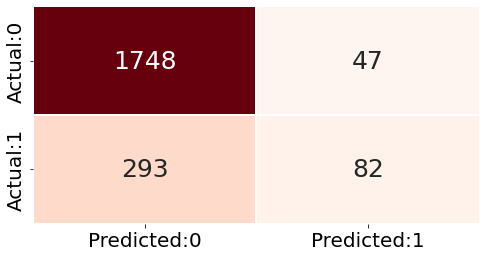

In [53]:
def plot_confusion_matrix(model):
    pred=model.predict(X_test_vif)
    cc=confusion_matrix(y_test,pred)
    plt.rcParams['figure.figsize']=(8,4)
    conf_matrix = pd.DataFrame(data = cc,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
    sns.heatmap(conf_matrix, annot= True, fmt = 'd', cmap ='Reds', cbar = False, linewidths = 0.1, annot_kws = {'size':25})
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.show()
print(1,': bad customer')
print(0,': good customer')
plot_confusion_matrix(lr4)